# Linear Regression

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import add_dummy_feature
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
#from sklearn.metrics import root_mean_squared_error
import warnings


warnings.filterwarnings("ignore")
np.random.seed(42) # to make this code example reproducible

## The Normal Equation for Linear Regression

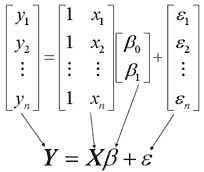

$\Beta = \theta$ it's a minor notation difference don't worry about it too much

Technically there is also some error in our approximation so $\epsilon$ is used to denote that but we will ignore that for now.

$$
Y = \theta X
$$



$$
\theta = (X^{T}X)^{-1}X^{T}Y
$$

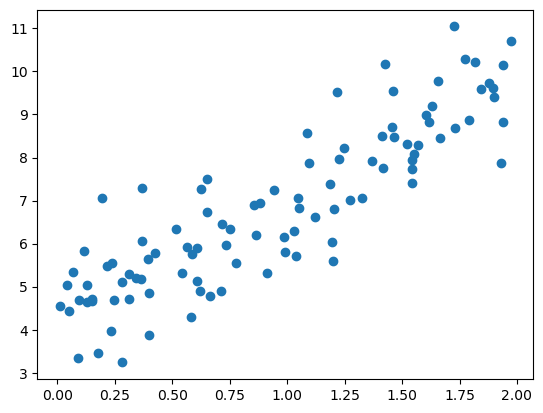

In [7]:
# generate m=100 random instances
# of a feature X and a target y
# y = 4 + 3x + Gaussian noise
m = 100 # number of instances
np.random.seed(42) # to make this code example reproducible

X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)

# plot a scatter plot of the data
plt.scatter(X, y)

In [8]:
# add x0 = 1 to each instance using sklearn
X_b = add_dummy_feature(X) # add x0 = 1 to each instance

# compute the best theta using the normal equation
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for $\theta_0 = 4$ and $\theta_1 = 3$.
Close enough, but the noise made it impossible to recover the exact parameters of the original function. The smaller and noisier the dataset, the harder it gets.

Now we can make predictions using vector $\theta$:

In [9]:
# predict the target for two new instances with x=0 and x=2
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new) # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

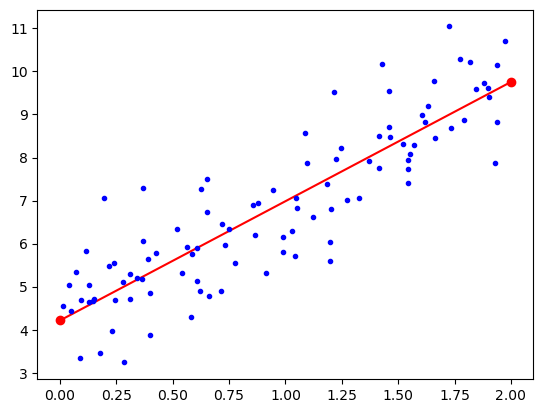

In [10]:
# plot the model's predictions, 
# since the model is linear
# and the predictions are for two points, 
# they are enough to draw the line
plt.plot(X_new, y_predict, 'ro')
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")

Performing linear regression using Scikit-Learn is relatively straightforward:

In [11]:
# perform linear regression using sklearn
# fit the model to the data
# show the intercept and the coefficients

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)

[4.21509616] [[2.77011339]]


Notice that Scikit-Learn separates the bias term (intercept_) from the feature
weights (coef_).

In [12]:
# predict the target for two new instances with x=0 and x=2
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

To perform linear regression using SGD with Scikit-Learn, you can use the SGDRegressor class, which defaults to optimizing the MSE cost function. 

The following code runs for maximum 1,000 epochs (`max_iter`) or until the loss drops by
less than $10^{–5}$ (`tol`) during 100 epochs (`n_iter_no_change`). 
It starts with a learning
rate of 0.01 (`eta0`), using the default learning schedule (different from the one we
used). Lastly, it does not use any regularization (`penalty=None`):

In [13]:
# perform linear regression using SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01)
sgd_reg.fit(X, y)

sgd_reg.intercept_, sgd_reg.coef_

(array([4.18109657]), array([2.80108918]))

## Polynomial Regression

What if your data is more complex than a straight line? Surprisingly, you can use a linear model to fit nonlinear data. 

A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called **polynomial regression**.

Let’s look at an example. First, we’ll generate some nonlinear data, based on a simple quadratic equation:
$y = ax^2 + bx + c$ plus some noise:

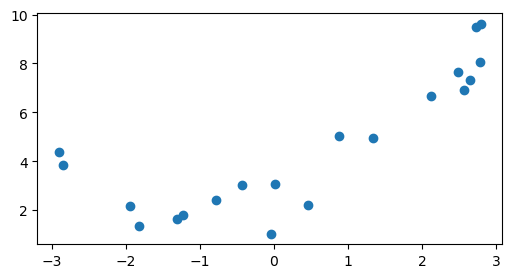

In [14]:
# generate random instances
# of a feature X and a target y
m = 20
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

plt.figure(figsize=(6, 3))
plt.scatter(X,y)

In [15]:
# generate polynomial features up to degree 2
# we don't include the bias term because X already has it
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([0.01582256]), array([0.01582256, 0.00025035]))

In [16]:
# fit a linear regression model to the data
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

lin_reg.intercept_, lin_reg.coef_

(array([2.43056615]), array([[0.9281665 , 0.47609759]]))

Not bad: the model estimates 
$y = 0.56x_1^2 + 0.93x_1 + 1.78$ when in fact the original function was 
$y = 0.5x_1^2 + 1.0x_1 + 2.0 + \text{Gaussian noise}$.

## Learning Curves

Another way to tell *underfitting* or *overfitting* is to look at the **learning curves**. 

They are plots of the model’s **training error** and **validation error** as a function of the training set size. 

`learning_curve()` function: retrains
and evaluates the model using **cross-validation** on growing subsets of the training set.

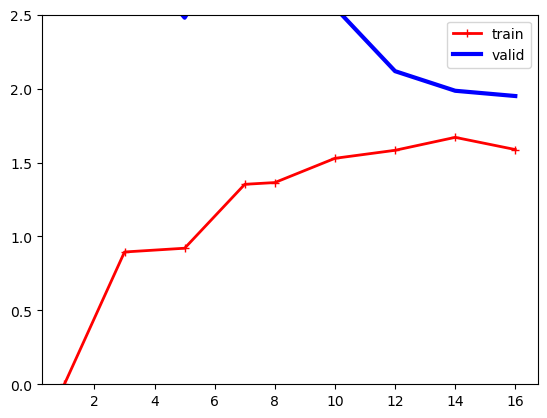

In [17]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, 
    train_sizes=np.linspace(0.01, 1.0, 10), 
    cv=5,
    scoring="neg_root_mean_squared_error")

# print(train_sizes, train_scores, valid_scores)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend()
plt.ylim(0, 2.5)
plt.show()


This model is **underfitting**. 

**Training error**: Starts low with few data points, then increases and plateaus due to noise and non-linearity as more instances are added.

**Validation error**: Initially high due to inadequate generalization; decreases as more examples are provided but plateaus, reflecting the model's limitations in capturing data complexity.

**Both errors plateau and remain high**, indicative of underfitting. 

Adding more data won't improve performance; enhancing the model or features is necessary.

Now let’s look at the learning curves of a 10th-degree polynomial model on the same
data:

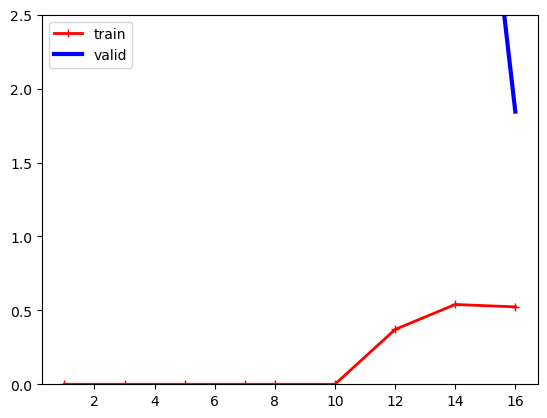

In [18]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, 
    train_sizes=np.linspace(0.01, 1.0, 10), 
    cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend()
plt.ylim(0, 2.5)
plt.show()

These learning curves look a bit like the previous ones, but there are two very
important differences:

* Error on training data much lower than before.
* There is a gap between the curves. This means that the model performs better on the training data than on the validation data, the hallmark of an **overfitting** model. In this particular figure, which is for $m=20$, the validation error is "off-the-chart", i.e. too big. 
* If you used a larger training set, however, the two curves would continue to get closer. For example if you change the number of randomly generated instances to $m=100$, you will see that the two curves will get much closer, in essence, have a significantly lower overfitting. 

## The Bias/Variance Trade-Off

An important theoretical result of statistics and machine learning is the fact that a model’s generalization error can be expressed as the sum of three very different
errors:

**Bias**

This part of the generalization error is due to wrong assumptions, such as
assuming that the data is linear when it is actually quadratic. A high-bias model
is most likely to **underfit** the training data.

**Variance**

This part is due to the model’s excessive sensitivity to small variations in the
training data. A model with many degrees of freedom (such as a high-degree
polynomial model) is likely to have high variance and thus **overfit** the training
data.

**Irreducible error**

This part is due to the noisiness of the data itself. The only way to reduce this
part of the error is to clean up the data (e.g., fix the data sources, such as broken
sensors, or detect and remove outliers).

Increasing a model’s complexity will typically increase its variance and reduce its bias.
Conversely, reducing a model’s complexity increases its bias and reduces its variance.
This is why it is called a trade-off.

## Stochastic Gradient Descent

The main problem with batch gradient descent is the fact that it uses the whole
training set to compute the gradients at every step, which makes it very slow when
the training set is large. 

At the opposite extreme, stochastic gradient descent picks a
random instance in the training set at every step and computes the gradients based
only on that single instance. 

To better converge as SGD approaches the minimum, we gradually decrease the learning rate.

## Regularized Linear Models

A good way to reduce overfitting is to regularize the model (i.e., to constrain it: the fewer degrees of freedom it has, the harder it will be for it to overfit the data. A simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model.

### Ridge Regression

**Ridge Regression** integrates regularization into linear regression, adding $\frac{\alpha}{m} \sum_{i=1}^n \theta_i^2$ to the MSE, encouraging smaller weights to combat overfitting. 

- **Regularization Impact:** During training, this term minimizes weights; post-training, performance is assessed via the original MSE or RMSE.
- **Hyperparameter $\alpha$:** Adjusts regularization intensity. $\alpha = 0$ reverts to linear regression; a high $\alpha$ flattens the model, pushing weights towards zero.
- **Cost Function:** $J(\theta) = \text{MSE}(\theta) + \frac{\alpha}{m} \sum_{i=1}^n \theta_i^2$, sparing the bias $\theta_0$ from regularization.
- **Gradient Adjustment:** For gradient descent, add $2\alpha \theta / m$ to the feature weights' gradient.
- **Effect of $\alpha$:** Increases in $\alpha$ yield flatter predictions, lowering variance but raising bias.

![Ridge Regression Visualization](https://raw.githubusercontent.com/thomouvic/SENG474/main/images/book/ridge.png)

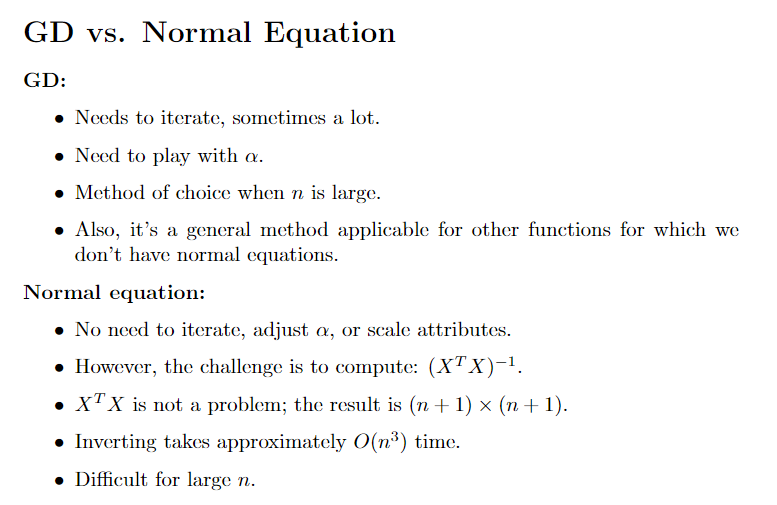

# STUDENT SECTION

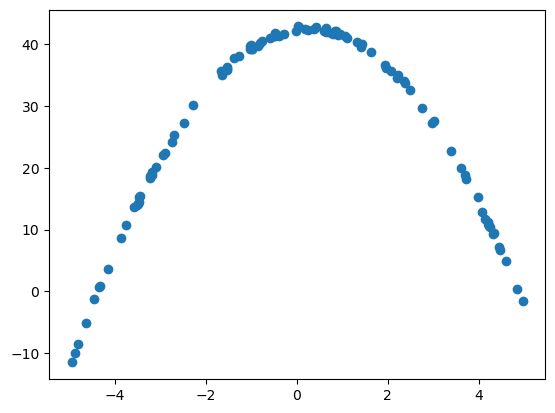

In [47]:
# generate 100 random instances
# of a feature X and a target y
# of the form:
# y = -2x^2 + X + 42 + noise
# Where noise is a random amount in range [0,1]
# And X is in range [-5,5]

m = 100
X = 10 * np.random.rand(m, 1) - 5
y = -2 * X ** 2 + X + 42 + np.random.rand(m, 1)

# plot the data
plt.scatter(X, y)

In [30]:
# Make a pipeline that generates polynomial features of degree 2 and then performs linear regression

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression())


In [31]:
# Fit the pipeline to the data set (X,y)

polynomial_regression.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

In [32]:
# Get the predictions on X

y_pred = polynomial_regression.predict(X)

In [43]:
# Store the coefficients of your polynomial in an array that has the form [a,b,c] and print it
# Hint: you can use .steps[1][1] to access the linear regressor in the pipeline

coefficients = polynomial_regression.steps[1][1].intercept_, polynomial_regression.steps[1][1].coef_
print(coefficients)

(array([42.56432759]), array([[ 1.01752363, -2.00490413]]))


In [48]:
# Print the RMSE between y and y_pred

print(sklearn.metrics.mean_squared_error(y, y_pred))


445.94022342298473


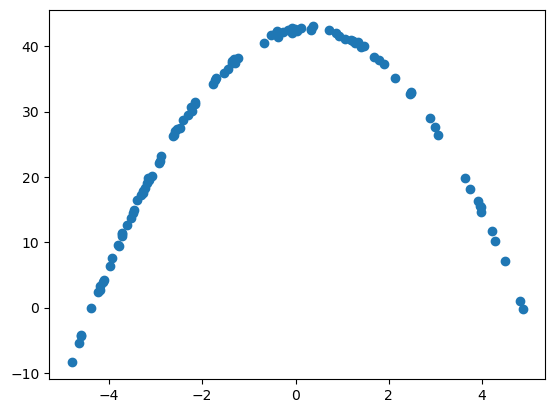

In [46]:
# Plot the data along with the polynomial generated by your model
# Use np.linspace with 100 points to draw your polynomial

X_new = np.linspace(-5, 5, 100).reshape(100, 1)
y_new = polynomial_regression.predict(X_new)

plt.scatter(X, y)